<a href="https://colab.research.google.com/github/sudddddd/2014/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from skimage import io, transform
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
vgg19=torchvision.models.vgg19(pretrained=True).to(device)

In [0]:
# Replace max pool with average pool
for i,val in enumerate(vgg19.features):
    if type(val)==nn.MaxPool2d:
        vgg19.features[i]=nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        
# Freeze all the layers
for param in vgg19.parameters():
    param.requires_grad = False

In [0]:
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)
    (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
 

In [0]:
# Get output at indices by passing x through model 
def get_output(x,model,content_ind,style_ind):
    content_out,style_out=[],[]
    for i,layer in enumerate(model.features):
        x=layer(x)
        if i in content_ind:
            content_out.append(x)
        if i in style_ind:
            style_out.append(x)
    return content_out[0], style_out

In [0]:
# Calculates content loss(MSE) between F and P
# P-original image activations and F-generated image activations 
def content_loss(P,F):
    loss=torch.sum((P-F)**2)
    return 0.5*loss

In [0]:
# Calculates gram matrix for list of activations
# output shape at each index- no. of channels x no. of channels
def calc_gram(A):
    newA=[]
    for val in A:
        val=val.squeeze(0)
        val=val.view(val.size(0),-1)   # dim- c x (w*h)
        val=torch.mm(val,val.t())
        newA.append(val)
    return newA

In [0]:
def style_loss(P,F,w):
    A=calc_gram(P)
    G=calc_gram(F)
    loss=0
    for i in range(len(P)):
        diff_loss=torch.sum((A[i]-G[i])**2)
        loss+=(diff_loss*w[i])/(P[i].size(-1)*P[i].size(1))**2
    return 0.25*loss

In [0]:
def total_loss(orig_cont, gen_cont, orig_style, gen_style,w, alpha, beta):
#     print(alpha*content_loss(orig_cont,gen_cont).item(),'c')
#     print(beta*style_loss(orig_style,gen_style,w).item(),'s')
    return alpha*content_loss(orig_cont,gen_cont)+ beta*style_loss(orig_style,gen_style,w)

In [0]:
# Normalizes x using mean and std
# dimension of x= w*h*c
# If reverse=False normalize, if reverse=True unnormalize
def normalize(x,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],reverse=False):
    mean=torch.tensor(mean)
    std=torch.tensor(std)

    if reverse:
        return x*std+mean
    else:
        return (x-mean)/std

In [0]:
# changes dim of x from (w,h,3)->(1,3,w,h) to easily pass through model 
def img_to_passable(x):
    x=x.permute((2,0,1))
    x=x.unsqueeze(0)
    return x

# inverse of img_to_passable
# converts (1,3,w,h) to (w,h,3)
def passable_to_img(x):
    x=x.squeeze(0)
    x=x.permute((1,2,0))
    return x

def clip(x):
    with torch.no_grad():
        x=passable_to_img(x)
        x=normalize(x,reverse=True)
    #     x=x.clip(0,1)
        x.data.clamp_(0, 1)  
        x=normalize(x)
        x=img_to_passable(x)
    return x

In [0]:
loader = transforms.Compose([
    transforms.Resize((512,512)),  # scale imported image
    transforms.ToTensor()])  # transform it(PIL) into a torch tensor

def load_image(name):
    image = Image.open(name)
    image = loader(image)
    return image.float().unsqueeze(0)

In [0]:
def train(content_image,style_image,x, content_indices,style_indices ,alpha,beta,w, model):
    content_image,style_image,x=list(map(lambda x: normalize(x).to(device), [content_image,style_image,x]))  # normalize the three images
    content_image,style_image,x=list(map(lambda x: img_to_passable(x), [content_image,style_image,x]))       # make the three images passable

    x.requires_grad=True   # we want to update the x so compute its gradients
    optimiser=optim.LBFGS([x])
    
    orig_content_act,_=get_output(content_image,model,content_indices,style_indices)
    _,orig_style_act = get_output(style_image,model,content_indices,style_indices)

    epochs=1000
    for i in range(epochs):

        def closure():
            optimiser.zero_grad()
            cont,style=get_output(x,model,content_indices,style_indices)
            loss=total_loss(orig_content_act,cont,orig_style_act,style,w,alpha,beta)
            loss.backward(retain_graph=True)
            return loss

        optimiser.step(closure)
        
        if i%10==0:
            print(i)
            y=x.squeeze(0)
            y=y.permute((1,2,0)).detach().cpu()
            y=normalize(y,reverse=True)
            y=y.numpy().clip(0,1)
            plt.figure(figsize=(7,7))
            plt.imshow(y)
            plt.show()

0


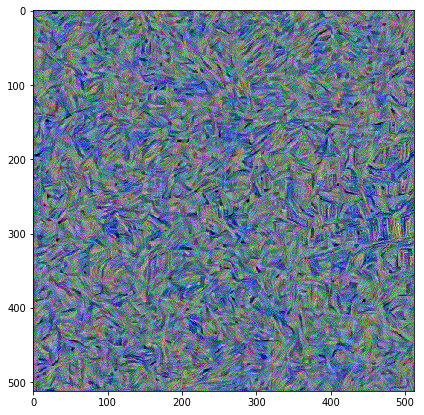

10


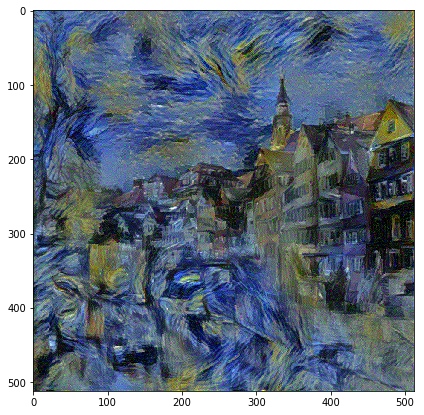

20


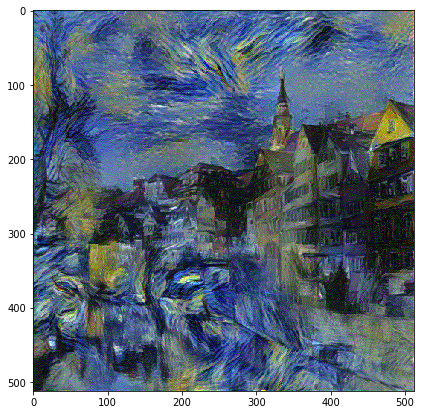

30


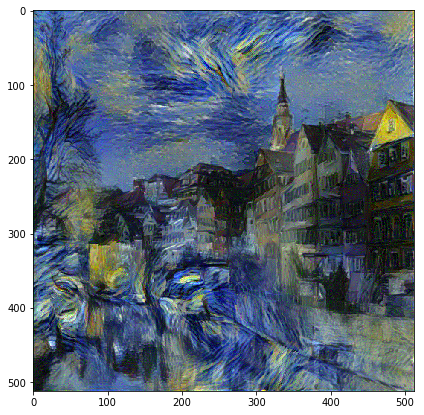

40


In [0]:
content= transform.resize(io.imread('/content/german.jpg'), (512,512),anti_aliasing=True,mode='reflect')
style=transform.resize(io.imread('/content/van.jpg'), (512,512),anti_aliasing=True,mode='reflect')

content_img=torch.tensor(content).float()
style_img=torch.tensor(style).float()

content_img=passable_to_img(load_image('/content/german.jpg'))
style_img=passable_to_img(load_image('/content/van.jpg'))

x=torch.rand(512,512,3)       # generated image which we change to get final output
# x=content_img.clone()

# Paper used these indices for content and style representations
content_indices={22:'conv4_2'}
style_indices={1:'conv1_1', 6:'conv2_1',11:'conv3_1',20:'conv4_1',29:'conv5_1'}

alpha,beta=16,1000000
# alpha,beta=8,10000
w=[0.2,0.2,0.2,0.2,0.2]

train(content_img,style_img,x ,content_indices,style_indices,alpha,beta,w,vgg19)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


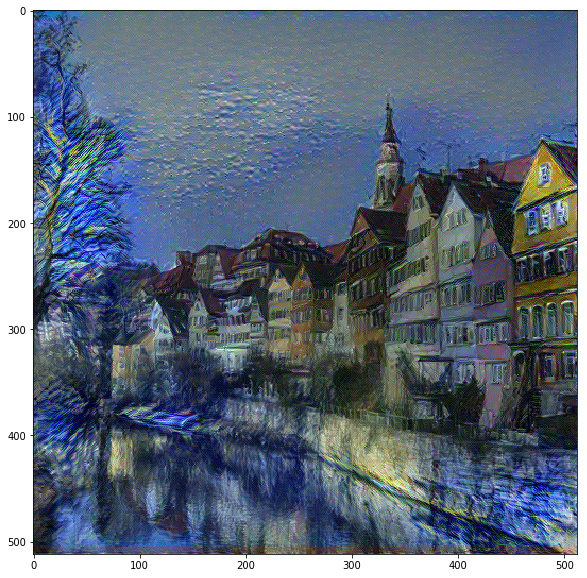

In [0]:
plt.figure(figsize=(10,10))
y=x.squeeze(0)
y=y.permute((1,2,0)).detach().cpu()
y=normalize(y,reverse=True)
plt.imshow(y.numpy())
plt.show()

In [0]:
torchvision.utils.save_image(normalize(x.cpu(),reverse=True),'q_1000.png')

(1.3109123, -0.4202034)

In [0]:
np.min(img)

0.0